In [1]:
import os
from glob import glob
import copy
from datetime import datetime
import distutils.dir_util
from shutil import copyfile
import ujson as json
import PIL


from matplotlib import pyplot as plt
%matplotlib inline
import bcolz
import numpy as np

from keras.utils.np_utils import to_categorical as one_hot

from keras.layers import Dense, Input, Lambda, BatchNormalization, Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Activation, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50, identity_block, conv_block
from keras.applications.imagenet_utils import preprocess_input
from keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.4


In [2]:
DATA_ROOT_DIR = "/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/"
TEST_STG1_DIR = DATA_ROOT_DIR + '/test_stg1/'
TEST_STG2_DIR = DATA_ROOT_DIR + '/test_stg2/'
RESULTS_DIR = DATA_ROOT_DIR + '/results/'

SAMPLE_ROOT_DIR = DATA_ROOT_DIR + "/sample/"
TRAIN_SAMPLE_DIR = SAMPLE_ROOT_DIR + '/train/'
VALID_SAMPLE_DIR = SAMPLE_ROOT_DIR + '/valid/'
TRAIN_DIR = DATA_ROOT_DIR + '/train/'
VALID_DIR = DATA_ROOT_DIR + '/valid/'

# 1. Prepare Data (create validation/sample sets, rearrange images by class dir)

Same as "the-nature-conservancy-fisheries-monitoring_v1-keras2.ipynb"

# 2. Finetune model on full data (not sample as small data)

In [3]:
def predict_generator_helper(model, batches, batch_size, num_batch_samples):
    # Be sure get_batches has used shuffle=False
    return model.predict_generator(batches,
                                   num_batch_samples // batch_size)
                                   #num_batch_samples)

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [4]:
# Create base model
resnet_base = ResNet50(include_top=False, weights='imagenet')

#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] # i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (1, 1, 2048)
classifier_input = Input(shape=classifier_input_shape)

### Precompute convolutional output (to save training time)

In [5]:
def preprocess_input(x, data_format=None):
    # Based on function at https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py
    # Altered for 3D input, assumes data_format='channels_last'
    
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 3D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

# Create (Raw Image) Batches
def get_batches(path,
                gen=ImageDataGenerator(preprocessing_function=preprocess_input),
                shuffle=True,
                batch_size=64,
                target_size=(224,224),
                class_mode='categorical'):
    return gen.flow_from_directory(path, 
                                   target_size=target_size,
                                   class_mode=class_mode,
                                   shuffle=shuffle, 
                                   batch_size=batch_size)

def create_precomputed_data(model, batches, batch_size):
    filenames = batches.filenames
    conv_features = predict_generator_helper(model, batches, batch_size, len(filenames))
    labels = one_hot(batches.classes)
    return (filenames, conv_features, labels)

def get_batch_data(batches):
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [ ]:
#batch_size = 32 # multiple of 2 and as large as you can (encourages more stable training), but no larger than 64.
trn_batch_size = 43 # ensure num_trn_sample/trn_batch_size is int.
val_batch_size = 38 # ensure num_val_sample/val_batch_size is int.
trn_batches = get_batches(TRAIN_DIR, batch_size=trn_batch_size, shuffle=False)
val_batches = get_batches(VALID_DIR, batch_size=val_batch_size, shuffle=False)

trn_filenames, trn_conv_features, trn_labels = create_precomputed_data(resnet_base, trn_batches, trn_batch_size)
val_filenames, val_conv_features, val_labels = create_precomputed_data(resnet_base, val_batches, val_batch_size)

num_trn_batch_samples, num_val_batch_samples = len(trn_filenames), len(val_filenames)

Found 3397 images belonging to 8 classes.
Found 380 images belonging to 8 classes.


In [ ]:
from vgg16bn import Vgg16BN

In [15]:
%mkdir -p $RESULTS_DIR/ResNet50_conv_feats

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def save_precomputed_data(filenames, conv_feats, labels, features_base_name="ResNet50_conv_feats/trn_"):
    save_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat', np.array(filenames))
    save_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat', conv_feats)
    save_array(RESULTS_DIR+"/"+features_base_name+'labels.dat', np.array(labels))
    
save_precomputed_data(trn_filenames, trn_conv_features, trn_labels, "ResNet50_conv_feats/trn_")
save_precomputed_data(val_filenames, val_conv_features, val_labels, "ResNet50_conv_feats/val_")

### Run finetuning

In [6]:
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="ResNet50_conv_feats/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels
                          
trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("ResNet50_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("ResNet50_conv_feats/val_")

In [7]:
assert len(trn_filenames) == 3397, "trn_filenames not as expected"
assert trn_conv_features.shape == (3397, 1, 1, 2048), "trn_conv_features not as expected"
assert trn_labels.shape == (3397, 8), "trn_labels not as expected"

assert len(val_filenames) == 380, "val_filenames not as expected"
assert val_conv_features.shape == (380, 1, 1, 2048), "val_conv_features not as expected"
assert val_labels.shape == (380, 8), "val_labels not as expected"

### Multi-Output

The images indicate that there is often a lot of noise in the images. Fortunately a kaggler has been through the training images and manually annotated the fish: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902

In [104]:
%cd $TRAIN_DIR
%mkdir manual_annotations
%cd manual_annotations
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147332/5471/other_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/158691/5864/NoF_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5459/shark_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5460/dol_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5461/yft_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5462/alb_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5463/lag_labels.json

--2017-05-12 13:42:33--  https://kaggle2.blob.core.windows.net/forum-message-attachments/158691/5864/NoF_labels.json
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.24
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333927 (326K) [application/json]
Saving to: ‘NoF_labels.json’

100%[======================================>] 333,927      914KB/s   in 0.4s   

2017-05-12 13:42:34 (914 KB/s) - ‘NoF_labels.json’ saved [333927/333927]

--2017-05-12 13:42:35--  https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.24
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82471 (81K) [application/json]
Saving to: 

In [8]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft', 'NoF']

LABELS_DIR = DATA_ROOT_DIR + "/manual_annotations"

bb_json = {}
for c in anno_classes:
    j = json.load(open(LABELS_DIR+'/{}_labels.json'.format(c), 'r'))
    for one_file in j:
        if 'annotations' in one_file.keys() and len(one_file['annotations'])>0:
            bb_json[one_file['filename'].split('/')[-1]] = sorted(
                one_file['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [9]:
# For any images that have no annotations, we'll create an empty bounding box.

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

print(len(bb_json))

raw_trn_filenames = [f.split("/")[-1] for f in trn_filenames]
raw_val_filenames = [f.split("/")[-1] for f in val_filenames]

for f in raw_trn_filenames:
    if f not in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
        
print(len(bb_json))
bb_json

3762
3777


{'img_00470.jpg': {'class': 'rect',
  'height': 160.00000000000057,
  'width': 206.00000000000063,
  'x': 350.0000000000012,
  'y': 379.00000000000125},
 'img_00412.jpg': {'class': 'rect',
  'height': 77.0,
  'width': 230.0,
  'x': 353.0,
  'y': 428.0},
 'img_02818.jpg': {'class': 'rect',
  'height': 304.0,
  'width': 268.0,
  'x': 817.0,
  'y': 256.0},
 'img_00687.jpg': {'class': 'rect',
  'height': 149.6167102966798,
  'width': 372.8543415329957,
  'x': 518.9087492035642,
  'y': 66.49631568741327},
 'img_01105.jpg': {'class': 'rect',
  'height': 105.75000000000148,
  'width': 63.45000000000084,
  'x': 819.2100000000112,
  'y': 272.1300000000037},
 'img_01912.jpg': {'class': 'rect',
  'height': 259.00000000000017,
  'width': 358.00000000000034,
  'x': 381.00000000000034,
  'y': 308.0000000000003},
 'img_06572.jpg': {'class': 'rect',
  'height': 122.22260310188136,
  'width': 143.98827214742187,
  'x': 53.57703149671511,
  'y': 381.7363494140952},
 'img_03158.jpg': {'class': 'rect',
  

In [10]:
# Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

bb_params = ['height', 'width', 'x', 'y']

def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

trn_sizes = [PIL.Image.open(TRAIN_DIR+f).size for f in trn_filenames]
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_trn_filenames, trn_sizes)], 
                   ).astype(np.float32)

val_sizes = [PIL.Image.open(VALID_DIR+f).size for f in val_filenames]
val_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, val_sizes)], 
                   ).astype(np.float32)

In [11]:
def to_plot(img):
    # Assumes tensorflow backend
    return np.rollaxis(img, 0, 1).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))

def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i, bbox, data):
    bb = bbox[i]
    plot(data[i])
    plt.gca().add_patch(create_rect(bb))
    
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size, gen=ImageDataGenerator())
    return np.concatenate([batches.next() for i in range(len(batches.filenames))])

trn_data = get_data(TRAIN_DIR)
val_data = get_data(VALID_DIR)

Found 3397 images belonging to 8 classes.
Found 380 images belonging to 8 classes.


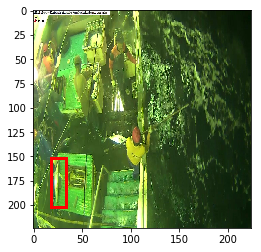

In [12]:
show_bb(0, trn_bbox, trn_data)

In [13]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.6

x = BatchNormalization()(classifier_input)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)
                                                     
resnet50_bb_v1 = Model([classifier_input], [x_bb, x_class])
resnet50_bb_v1.compile(Adam(lr=0.01), 
                    loss=['mse', 'categorical_crossentropy'],
                    metrics=['accuracy'], 
                    loss_weights=[.001, 1.])

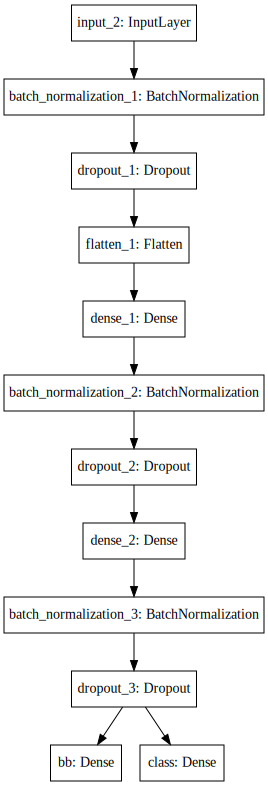

In [49]:
#from keras.utils import plot_model
#plot_model(resnet50_bb_v1, to_file='model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(resnet50_bb_v1).create(prog='dot', format='svg'))

In [17]:
def fit_precomputed_helper_multi_output(model, result_dir_name, batch_size=32, lr=0.1, nb_epoch=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit(trn_conv_features, [trn_bbox, trn_labels],
              batch_size=batch_size, 
              nb_epoch=nb_epoch,
              validation_data=(val_conv_features, [val_bbox, val_labels]),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    model.save_weights(results_dir + now)
    return model

In [23]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_v1", lr=0.01, nb_epoch=5)
# Ran lots times

Train on 3397 samples, validate on 380 samples
Epoch 1/5
 512/3397 [===>..........................] - ETA: 1s - loss: 0.5284 - bb_loss: 351.3418 - class_loss: 0.1770 - bb_acc: 0.8184 - class_acc: 0.9512

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


3397/3397 [==============================] - 1s - loss: 0.5102 - bb_loss: 390.2855 - class_loss: 0.1199 - bb_acc: 0.7845 - class_acc: 0.9656 - val_loss: 0.5986 - val_bb_loss: 359.3177 - val_class_loss: 0.2392 - val_bb_acc: 0.8263 - val_class_acc: 0.9605

In [28]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_v1", lr=0.0001, nb_epoch=5)
# Ran lots times

Train on 3397 samples, validate on 380 samples
Epoch 1/5
 480/3397 [===>..........................] - ETA: 1s - loss: 0.3975 - bb_loss: 337.9979 - class_loss: 0.0595 - bb_acc: 0.8063 - class_acc: 0.9771

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


3397/3397 [==============================] - 1s - loss: 0.4181 - bb_loss: 357.6866 - class_loss: 0.0604 - bb_acc: 0.7931 - class_acc: 0.9803 - val_loss: 0.4870 - val_bb_loss: 340.2077 - val_class_loss: 0.1468 - val_bb_acc: 0.8500 - val_class_acc: 0.9684

In [30]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_v1", lr=0.000001, nb_epoch=5)
# Ran 2 times

Train on 3397 samples, validate on 380 samples
Epoch 1/5
 512/3397 [===>..........................] - ETA: 1s - loss: 0.3842 - bb_loss: 333.2862 - class_loss: 0.0509 - bb_acc: 0.8047 - class_acc: 0.9805

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


3397/3397 [==============================] - 1s - loss: 0.4307 - bb_loss: 353.8195 - class_loss: 0.0768 - bb_acc: 0.8031 - class_acc: 0.9744 - val_loss: 0.4878 - val_bb_loss: 340.1757 - val_class_loss: 0.1476 - val_bb_acc: 0.8474 - val_class_acc: 0.9711

Much improved! Let's evaluate visually:

In [36]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val_data[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

In [41]:
pred = resnet50_bb_v1.predict(val_conv_features[0:10])

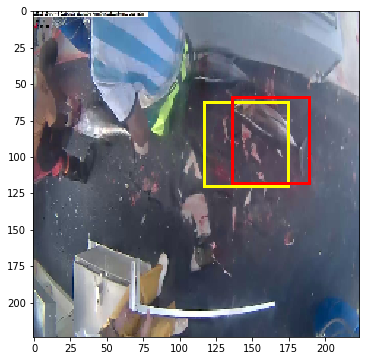

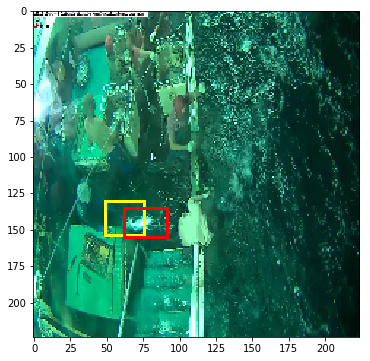

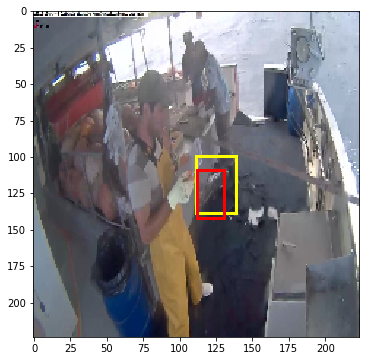

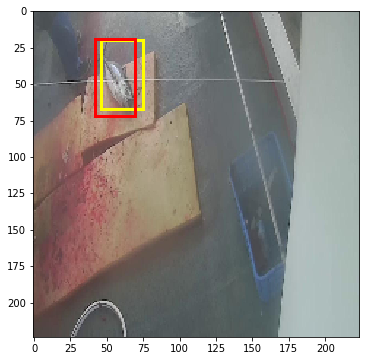

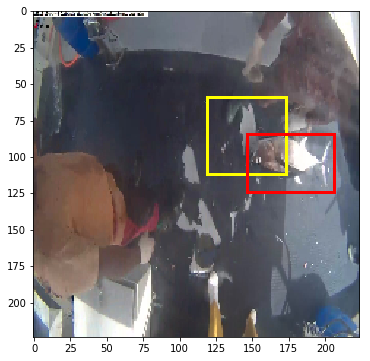

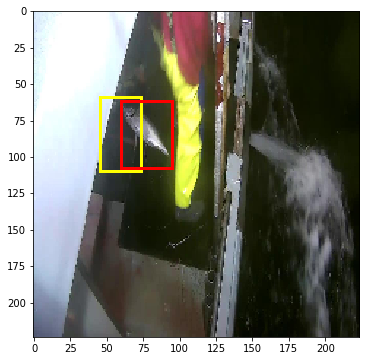

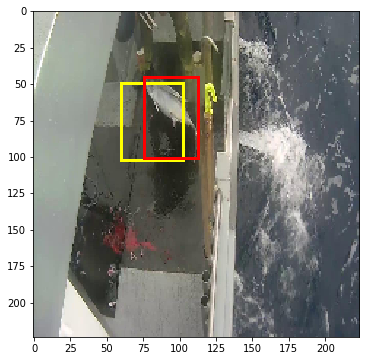

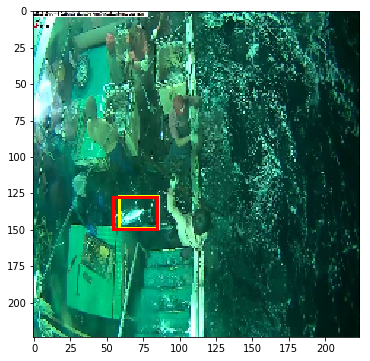

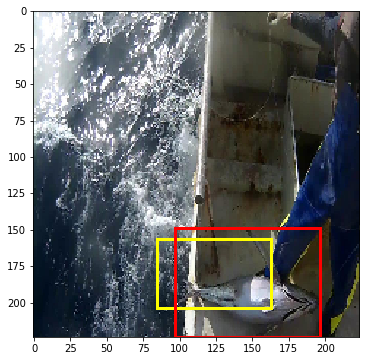

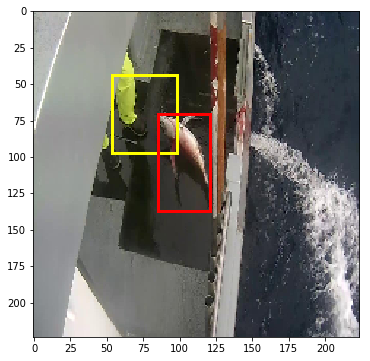

In [44]:
show_bb_pred(0)
show_bb_pred(1)
show_bb_pred(2)
show_bb_pred(3)
show_bb_pred(4)
show_bb_pred(5)
show_bb_pred(6)
show_bb_pred(7)
show_bb_pred(8)
show_bb_pred(9)

# 3. Generate and Validate Predictions

In [118]:
def do_clip(arr, mx, num_classes): return np.clip(arr, (1-mx)/(num_classes-1), mx)

In [83]:
# Get Data
test_batch_size = 3 # ensure num_test_sample/test_batch_size is int.
test_batches = get_batches(TEST_STG2_DIR, batch_size=1, shuffle=False)

Found 12153 images belonging to 1 classes.


In [116]:
class_predictions = []

for one_image in test_batches:
    #print(one_image[0].shape)
    test_conv_features = resnet_base.predict(one_image[0], batch_size=1)
    prediction = resnet50_bb_v1.predict(test_conv_features, batch_size=1)
    class_predictions.append(prediction[1])

In [119]:
preds = np.array(class_predictions)

In [124]:
subm = do_clip(preds, 0.82, 8)
subm_name = RESULTS_DIR+'resnet50_bb_v1/subm_bb.gz'
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [142]:
np.squeeze(subm)

array([[ 0.15097414,  0.02571429,  0.02571429,  0.02571429,  0.58164519,
         0.26565433,  0.02571429,  0.02571429],
       [ 0.81999999,  0.02571429,  0.02571429,  0.02571429,  0.0942843 ,
         0.02571429,  0.04335111,  0.02571429],
       [ 0.81999999,  0.02571429,  0.02571429,  0.02571429,  0.03317143,
         0.02571429,  0.02571429,  0.02571429]], dtype=float32)

In [ ]:
import pandas as pd

submission = pd.DataFrame(np.squeeze(subm), columns=classes)
submission.insert(0, 'image', test_batches.filenames)
submission.head()

In [144]:
submission


,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.150974,0.025714,0.025714,0.025714,0.581645,0.265654,0.025714,0.025714
1,0.820000,0.025714,0.025714,0.025714,0.094284,0.025714,0.043351,0.025714
2,0.820000,0.025714,0.025714,0.025714,0.033171,0.025714,0.025714,0.025714


In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [82]:
model_top_input = Input(shape=resnet_base.layers[-1].output_shape[1:])
x = BatchNormalization()(model_top_input)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)


ValueError: The shape of the input to "Flatten" is not fully defined (got (None, None, 2048). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

In [81]:
full_model = Model([model_top_input], [x_bb, x_class])
full_model.compile(Adam(lr=0.01), 
                    loss=['mse', 'categorical_crossentropy'],
                    metrics=['accuracy'], 
                    loss_weights=[.001, 1.])



NameError: name 'model_top_input' is not defined

In [73]:
resnet_base.input

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [71]:
from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)

In [75]:
resnet50_bb_v1.output

[<tf.Tensor 'bb/BiasAdd:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'class/Softmax:0' shape=(?, 8) dtype=float32>]